In [1]:
!pip install keras==2.1.2

     |████████████████████████████████| 307kB 9.0MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.2 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [12]:
## authorize access to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# navigate to project directory
# %cd '/content/drive/My Drive/Colab Notebooks/Proj'
%cd '/content/drive/My Drive/Proj/'

/content/drive/.shortcut-targets-by-id/1dru5PCdCB6aT1Kb-75g8GYG37BEdecQR/Proj


In [18]:
"""
    解决：如果有100个类，如何划分，训练集、验证集和测试集。可以60个类训练、20个验证，最后20个测试。
"""
# import keras
# from keras_preprocessing import image
#import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
#import keras
#from keras import layers
# from keras_preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_datasets as tfds
import Func_ReadAllData
import ReadData
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, MaxPooling1D, Conv2D, MaxPooling2D
import copy

import os
import keras.backend.tensorflow_backend as KTF
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.compat.v1.Session(config=config)
KTF.set_session(session)

In [ ]:
# set_path = []
# set_path.append(os.path.join("split2","train"))
# set_path.append(os.path.join("split2","test"))
# for set in set_path:
#   list = os.listdir(set) #获取所有person的name
#   for dir in trainList:
#       matlabPath = os.path.join(set, dir)
#       file_list = os.listdir(matlabPath)
#       for file in file_list:
#         if(file.split(''))

In [19]:
"""
## Define the Hyperparameters
"""
learning_rate = 0.003 # 0.003
meta_step_size = 0.1 # 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000  # 8000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20  # 20 5
shots = 40  # 5

classes = 2  # 5


import readData
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from Collected data that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        self.data = {}
        data_train, labels_train = ReadData.loadData(startPath="split2",training=training)
        for data_tmp, label_tmp in zip(data_train, labels_train):
            data_tmp = np.expand_dims(data_tmp, axis=2)
            if label_tmp not in self.data:
                self.data[label_tmp] = []
            self.data[label_tmp].append(data_tmp)
            self.labels = list(self.data.keys())

            

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False, test=False
    ):
        testImage = {}
        testLabels = {}
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 2000, 39, 1))
        if split:
            keys = np.zeros(shape=(num_classes))
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 2000, 39, 1))

        # Get a random subset of labels from the entire label set.

        label_subset =[]
        label_subset = np.array(label_subset)
        tmpLabels = copy.deepcopy(self.labels)
        for i in range(num_classes):                                # num_classes 次不放回采样
            tmp = random.choices(tmpLabels,k=1)
            label_subset = np.concatenate((label_subset,tmp),axis=0)
            tmpLabels.remove(tmp[0])
        # label_subset = random.choices(self.labels, k=num_classes)  # k 次有放回采样
        for class_idx, class_obj in enumerate(label_subset):
            test = []
            if class_obj not in testImage:
              testImage[class_obj] = []
              testLabels[class_obj] = []
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            # print(class_obj)
            # temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx

            # If creating a split dataset for testing, select an extra sample from each label to create the test dataset.
            if split:
                # test_labels[class_idx] = class_idx
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1   # 选出shot + 1个data
                )
                # if test:
                #   keys[class_idx] = class_obj
                #   for image in self.data[label_subset[class_idx]]:
                #     temp = False
                #     flags = (image==images_to_split[:-1])
                #     for idx, flag in enumerate(flags):
                #       if flag.all():
                #         temp = True
                #         break
                #     if not(temp):
                #       testImage[class_obj].append(image)
                #       testLabels[class_obj].append(class_idx)

                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)  #打乱，喂入batch size，迭代repetitions次
        # if test:
        #   tmpImage = []
        #   tmpLabels = []
        #   for i in range(len(list(testLabels.values())[0])):
        #     for k in testLabels.keys():
        #       tmpImage.append(list(testImage[k])[i])
        #       tmpLabels.append(list(testLabels[k])[i])
        #   tmpImage = np.array(tmpImage)
        #   tmpLabels = np.array(tmpLabels)
        #   testset = tf.data.Dataset.from_tensor_slices((tmpImage.astype(np.float32), tmpLabels.astype(np.float32)))
        #   testset = testset.batch(5)
        #   return dataset, test_images, test_labels, keys, testset
        if split:
            return dataset, test_images, test_labels
        return dataset



In [8]:
train_dataset = Dataset(training=False)
test_dataset = Dataset(training=True)

personlist:['ZCY', 'ZJS', 'QinDang', 'XueMeng', 'ZhuTianLin', 'XZQ', 'ZhuXiaoTian', 'OuRunMin', 'WuYuan', 'WZY', 'ZJ', 'ZSF', 'ZJX', 'ZT']
ZCY


/content/drive/.shortcut-targets-by-id/1dru5PCdCB6aT1Kb-75g8GYG37BEdecQR/Proj/ReadData.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nda = np.array(data).shape[0]


ZJS
QinDang
XueMeng
ZhuTianLin
XZQ
ZhuXiaoTian
OuRunMin
WuYuan
WZY
ZJ
ZSF
ZJX
ZT


/content/drive/.shortcut-targets-by-id/1dru5PCdCB6aT1Kb-75g8GYG37BEdecQR/Proj/ReadData.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dataValue = np.array(dataValue)
/content/drive/.shortcut-targets-by-id/1dru5PCdCB6aT1Kb-75g8GYG37BEdecQR/Proj/ReadData.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labelsValue = np.array(labelsValue)


personlist:['MZY', 'KuangRuiLin', 'HuHaiYan', 'LiLinWei', 'LPY', 'GQY', 'DengYangTao', 'BiHongLiang', 'HuangJiaQian', 'CZP', 'FCK', 'GZ', 'LT']
MZY
KuangRuiLin
HuHaiYan
LiLinWei
LPY
GQY
DengYangTao
BiHongLiang
HuangJiaQian
CZP
FCK
GZ
LT


In [ ]:
"""
## Build the model
"""
# def conv_bn(x):
#     x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     return layers.ReLU()(x)
#
# inputs = layers.Input(shape=(2000, 39, 1))
# x = conv_bn(inputs)
# x = conv_bn(x)
# x = conv_bn(x)
# x = conv_bn(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense(classes, activation="softmax")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
"""
## Change the model
"""
# X_input = Input(input_shape)
inputs = layers.Input(shape=(2000, 39, 1)) #, 1
X = Conv2D(filters=32, kernel_size=4, strides=1, name='conv0')(inputs) # 32
X = Activation('relu')(X)
# X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=2, strides=2, name='max_pool0')(X) #pool_size=2, strides=2 (4)

X = Conv2D(256, 4, strides=1, name='conv1')(X)  # filter setting. 64
X = Activation('relu')(X)
# X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=2, strides=2, name='max_pool01')(X)

X = Conv2D(128, 4, strides=1, name='conv11')(X)  # filter setting. #128
X = Activation('relu')(X)
# X = Dropout(0.3)(X)
X = MaxPooling2D(pool_size=2, strides=2, name='max_pool1')(X)

X = Conv2D(64, 4, strides=1, name='conv2', padding="same")(X)  # filter setting. # 256
X = Activation('relu')(X)
# X = Dropout(0.3)(X)

X = MaxPooling2D(pool_size=2, strides=2, name='max_pool')(X) #2
X = layers.Flatten()(X)
X = layers.Dense(classes, activation='softmax', name='fc')(X)
model = keras.Model(inputs=inputs, outputs=X, name='VoiceChestModel_Keras')

model.compile(metrics=['accuracy'])
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
model = tf.keras.models.load_model(os.path.join("checkpoint","model1.h5"))

In [ ]:
training = np.load(os.path.join("checkpoint","traing1.npy"))
testing = np.load(os.path.join("checkpoint","testing1.npy"))

In [ ]:
print(len(training))
print(len(testing))

1051
1051


In [12]:
"""
## Train the model
"""
# allData, allLabels = Func_ReadAllData.loadAllData(finalPath,1,training)
# allData = np.expand_dims(allData, axis=3)
# tmpAllLabels = []
# for label in allLabels:
#   tmpAllLabels.append(ord(label)-65)

# tmpAllLabels = np.array(tmpAllLabels)
import os
training = []
testing = []
labelAcc = {}
labelSum = {}
count = 0
print("开始")
start_iter = 0
# start_iter = len(training)
for meta_iter in range(start_iter,meta_iters):
  
  frac_done = meta_iter / meta_iters
  cur_meta_step_size = (1 - frac_done) * meta_step_size 

  # Temporarily save the weights from the model.
  old_vars = model.get_weights()
  # Get a sample from the full dataset. Train the few-shot.
  mini_dataset = train_dataset.get_mini_dataset(
      inner_batch_size, inner_iters, train_shots, classes
  )

  for images, labels in mini_dataset: #？
    with tf.GradientTape() as tape:
      preds = model(images)
      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(target=loss, sources=model.trainable_weights) 
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  new_vars = model.get_weights()
  # Perform SGD for the meta step.  SGD：对每个样本进行更新
  for var in range(len(new_vars)):
    new_vars[var] = old_vars[var] + (
        (new_vars[var] - old_vars[var]) * cur_meta_step_size)
  
  # After the meta-learning step, reload the newly-trained weights into the model.
  model.set_weights(new_vars)


  # Evaluation loop
  if meta_iter % eval_interval == 0:
    accuracies = []
    for dataset in (train_dataset, test_dataset):
      count+=1
      # Sample a mini dataset from the full dataset.
      train_set, test_images, test_labels = dataset.get_mini_dataset(
        eval_batch_size, eval_iters, shots, classes, split=True)
      # print(len(train_set),len(test_images),len(test_labels))
      old_vars = model.get_weights()
      # Train on the samples and get the resulting accuracies.
      for images, labels in train_set:
        # print(len(images),len(labels))
        with tf.GradientTape() as tape:
          preds = model(images)
          loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(target=loss, sources=model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
      test_preds = model.predict(test_images)
      test_preds = tf.argmax(test_preds).numpy()
      # print("labels:{}, preds:{}".format(test_labels,test_preds))

      # test_loss, test_acc= model.evaluate(allData,tmpAllLabels)
      # print(test_loss,test_acc)
      
      num_correct = (test_preds == test_labels).sum()
      # Reset the weights after getting the evaluation accuracies.
      model.set_weights(old_vars)
      accuracies.append(num_correct / classes)
    training.append(accuracies[0])
    testing.append(accuracies[1])

    if meta_iter % 10 == 0:
      
      print(
          "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
      )
      np.save(os.path.join("checkpoint","traing_2way.npy"),training)
      np.save(os.path.join("checkpoint","testing_2way.npy"),testing)

    #保存模型
    if meta_iter % 100 == 0:
      ModelName = os.path.join("checkpoint","model_2way.h5")
      model.save(ModelName)
    
    if meta_iter % 1999 == 0:
      ModelName = os.path.join("checkpoint","model_2way.h5")
      model.save(ModelName)

开始
batch 0: train=1.000000 test=1.000000
batch 10: train=1.000000 test=1.000000
batch 20: train=1.000000 test=1.000000
batch 30: train=1.000000 test=1.000000
batch 40: train=1.000000 test=1.000000
batch 50: train=1.000000 test=1.000000
batch 60: train=1.000000 test=0.000000
batch 70: train=1.000000 test=1.000000
batch 80: train=1.000000 test=1.000000
batch 90: train=1.000000 test=1.000000
batch 100: train=1.000000 test=1.000000
batch 110: train=1.000000 test=1.000000
batch 120: train=1.000000 test=1.000000
batch 130: train=1.000000 test=1.000000
batch 140: train=1.000000 test=1.000000
batch 150: train=1.000000 test=1.000000
batch 160: train=1.000000 test=1.000000
batch 170: train=1.000000 test=1.000000
batch 180: train=1.000000 test=1.000000
batch 190: train=1.000000 test=1.000000
batch 200: train=1.000000 test=1.000000
batch 210: train=1.000000 test=1.000000
batch 220: train=1.000000 test=1.000000
batch 230: train=1.000000 test=1.000000
batch 240: train=1.000000 test=1.000000
batch 25

In [ ]:
# model.save("model_2000_3_2.h5")
# np.save("training_3.npy",training)
# np.save("testing_3.npy",testing)

In [ ]:
# model = tf.keras.models.load_model("checkpoint/model1.h5")

In [22]:
training = np.load("checkpoint/traing_2way.npy")
testing = np.load("checkpoint/testing_2way.npy")

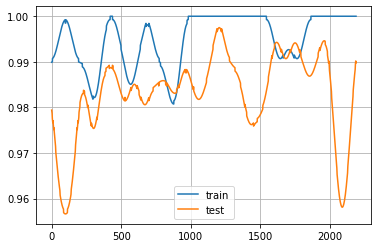

In [23]:
# First, some preprocessing to smooth the training and testing arrays for display.
import matplotlib.pyplot as plt
window_length = 200
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid") # Numpy 中的卷积函数
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(train_y), 1)
plt.plot(x, train_y, x, test_y)
# plt.plot(x,train_y)
# plt.plot(training)
plt.legend(["train","test"])
plt.grid()

In [ ]:
import copy
test_size = 45
class testDataset:
    # This class will facilitate the creation of a few-shot dataset
    # from Collected data that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        self.data = {}
        self.test_data = {}
        data_train, labels_train = ReadData.loadData(startPath="split2",training=training)
        # data_test, labels_test = ReadData.loadData(startPath=os.path.join("split2","tmp"),training=training)
        for data_tmp, label_tmp in zip(data_train, labels_train):
            data_tmp = np.expand_dims(data_tmp, axis=2)
            if label_tmp not in self.data:
                self.data[label_tmp] = []
            self.data[label_tmp].append(data_tmp)
            self.labels = list(self.data.keys())
        # for data_tmp, label_tmp in zip(data_test, labels_test):
        #     data_tmp = np.expand_dims(data_tmp, axis=2)
        #     if label_tmp not in self.test_data:
        #         self.test_data[label_tmp] = []
        #     self.test_data[label_tmp].append(data_tmp)
        #     # self.test_labels = list(self.test_data.keys())

            

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False, test=False
    ):
        testImage = {}
        testLabels = {}
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 2000, 39, 1))
        if split:
            keys = [0 for i in range(num_classes)]
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 2000, 39, 1))

        # Get a random subset of labels from the entire label set.
        # label_subset = random.choices(self.labels, k=num_classes)  # k 次有放回采样
        label_subset =[]
        label_subset = np.array(label_subset)
        tmpLabels = copy.deepcopy(self.labels)
        for i in range(num_classes):                                # num_classes 次不放回采样
            tmp = random.choices(tmpLabels,k=1)
            label_subset = np.concatenate((label_subset,tmp),axis=0)
            tmpLabels.remove(tmp[0])
        for class_idx, class_obj in enumerate(label_subset):
            if class_obj not in testImage:
              # testImage[class_obj] = []
              # testLabels[class_obj] = []
              testImage[class_obj] = np.zeros(shape=(test_size, 2000, 39, 1))
              testLabels[class_obj] = np.zeros(shape=(test_size))
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            # print(class_obj)
            # temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx

            # If creating a split dataset for testing, select an extra sample from each label to create the test dataset.
            if split:
                # test_labels[class_idx] = class_idx
                test_labels[class_idx] = class_idx
                # images_to_split = random.choices(
                #     self.data[label_subset[class_idx]], k=shots + 1   # 选出shot + 1个data
                # )
                images_to_split = self.data[label_subset[class_idx]][0:shots+1]
                
                if test:
                  keys[class_idx] = class_obj

                  # if(label_subset[class_idx]=="GQY"):
                  #   print(label_subset[class_idx]+"_25")
                  #   testImage[class_obj] = random.choices(self.test_data[label_subset[class_idx]+"_25"],k=test_size)
                  #   testLabels[class_obj][0:] = class_idx 
                  # else:
                  #   testImage[class_obj] = random.choices(self.data[label_subset[class_idx]][shots+1:],k=test_size)
                  #   testLabels[class_obj][0:] = class_idx
                   
                  testImage[class_obj] = random.choices(self.data[label_subset[class_idx]][shots+1:],k=test_size)
                  testLabels[class_obj][0:] = class_idx 

                  # print("keys:{}".format(keys))

                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)  #打乱，喂入batch size，迭代repetitions次
        if test:
          tmpImage = []
          tmpLabels = []
          # print(len(list(testLabels.values())[0]))
          l = len(list(testLabels.values())[0])
          # print(l)
          for i in range(l):
            for k in label_subset:
              # print("i:{},lemgth:{}".format(i,len(list(testImage[k]))))
              # print("length:{},idx:{}".format(len(list(testImage[k])),i))
              tmpImage.append(list(testImage[k])[i])
              
              tmpLabels.append(list(testLabels[k])[i])
          # print(len(tmpImage))
          tmpImage = np.array(tmpImage)
          tmpLabels = np.array(tmpLabels)
          testset = tf.data.Dataset.from_tensor_slices((tmpImage.astype(np.float32), tmpLabels.astype(np.float32)))
          testset = testset.batch(num_classes)
          keys = np.array(keys)
          return dataset, test_images, test_labels, keys, testset
        if split:
            return dataset, test_images, test_labels
        return dataset


In [ ]:
testSet = testDataset(False)

personlist:['ZCY', 'ZJS', 'QinDang', 'XueMeng', 'ZhuTianLin', 'XZQ', 'ZhuXiaoTian', 'OuRunMin', 'WuYuan', 'WZY', 'ZJ', 'ZSF', 'ZJX', 'ZT']
ZCY


/content/drive/My Drive/Colab Notebooks/Proj/ReadData.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  nda = np.array(data).shape[0]


ZJS
QinDang
XueMeng
ZhuTianLin
XZQ
ZhuXiaoTian
OuRunMin
WuYuan
WZY
ZJ
ZSF
ZJX
ZT


/content/drive/My Drive/Colab Notebooks/Proj/ReadData.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dataValue = np.array(dataValue)
/content/drive/My Drive/Colab Notebooks/Proj/ReadData.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  labelsValue = np.array(labelsValue)


In [ ]:
# testing = []
# all_count = {}  #保存各个类被抽取出的总次数
# label_dic = {}  #保存各个类被抽取出来后预测正确的次数，与上面的总次数相除暂定为预测的准确度
# train_set, test_images, test_labels, keys, test_set = testSet.get_mini_dataset(
#       eval_batch_size, eval_iters, shots, classes, split=True, test=True
#   )
# print(test_set)
# for l in keys:
#   if l not in label_dic:
#     label_dic[l]=0
#   if l not in all_count:
#     all_count[l]=0

In [ ]:
# model.compile(metrics=['accuracy'])
# optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
# model = tf.keras.models.load_model("checkpoint/model1.h5")

In [ ]:
number = 200
acc = {}
for shots in range(1,21,1):
  print("shots:{}".format(shots))
# shots=5
# test_size = 45

  all_count = {}  #保存各个类被抽取出的总次数
  label_dic = {}  #保存各个类被抽取出来后预测正确的次数，与上面的总次数相除暂定为预测的准确度
  for i in range(number):
    testing = []
    train_set, test_images, test_labels, keys, test_set = testSet.get_mini_dataset(
          eval_batch_size, eval_iters, shots, classes, split=True, test=True
      )
    # print(test_set)
    for l in keys:
      if l not in label_dic:
        label_dic[l]=0
      if l not in all_count:
        all_count[l]=0
    old_vars1 = model.get_weights()
    # train
    for images, labels in train_set:
      # print(labels)
      with tf.GradientTape() as tape:
          preds = model(images)
          loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
      # print(loss)
      # print("labels:{}, preds:{}".format(labels,preds))
      grads = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
    test_preds = model.predict(test_images)
    test_preds = tf.argmax(test_preds).numpy()
    if(i%50==0):
      print(i)
    # print(i)
    # print("labels:{}, preds:{}".format(test_labels,test_preds))
    # test
    for images, labels in test_set:
        old_vars2 = model.get_weights()
        for label in labels:
          # print(label.numpy())
          all_count[keys[label.numpy().astype(int)]]+=1 
        preds = model.predict(images)
        preds = tf.argmax(preds).numpy()
        # print("labels:{}, preds:{}".format(labels,preds))
        flags = (labels==preds)
        num_correct = flags.numpy().sum()
        testing.append(num_correct/classes)
        for idx, flag in enumerate(flags):
          if flag:
            label_dic[keys[idx]]+=1
        model.set_weights(old_vars2)
    model.set_weights(old_vars1)
  result = {}
  for key in label_dic.keys():
    result[key] = (label_dic[key]/all_count[key])*100
    print("label:{},  抽取出来的总次数:{},  其中预测正确的次数:{},  acc:{:.2f}%".format(key,all_count[key],label_dic[key],(label_dic[key]/all_count[key])*100))
  with open("result/lables1_{}.txt".format(shots),"w") as f:
    f.write(str(result))
    # f.write(str(label_dic))
    # f.write(str(all_count))
  print("shots:{}\n".format(shots))

shots:1
0
50
100
150
label:XueMeng,  抽取出来的总次数:1935,  其中预测正确的次数:1309,  acc:67.65%
label:ZhuXiaoTian,  抽取出来的总次数:1440,  其中预测正确的次数:1307,  acc:90.76%
label:QinDang,  抽取出来的总次数:1980,  其中预测正确的次数:1903,  acc:96.11%
label:WuYuan,  抽取出来的总次数:2205,  其中预测正确的次数:1278,  acc:57.96%
label:XZQ,  抽取出来的总次数:1620,  其中预测正确的次数:1255,  acc:77.47%
label:OuRunMin,  抽取出来的总次数:2025,  其中预测正确的次数:1218,  acc:60.15%
label:ZCY,  抽取出来的总次数:1890,  其中预测正确的次数:1617,  acc:85.56%
label:ZJ,  抽取出来的总次数:2070,  其中预测正确的次数:1491,  acc:72.03%
label:ZJX,  抽取出来的总次数:2340,  其中预测正确的次数:1642,  acc:70.17%
label:ZhuTianLin,  抽取出来的总次数:2205,  其中预测正确的次数:1732,  acc:78.55%
label:ZT,  抽取出来的总次数:1890,  其中预测正确的次数:1561,  acc:82.59%
label:ZJS,  抽取出来的总次数:1530,  其中预测正确的次数:1271,  acc:83.07%
label:WZY,  抽取出来的总次数:1755,  其中预测正确的次数:1217,  acc:69.34%
label:ZSF,  抽取出来的总次数:2115,  其中预测正确的次数:1323,  acc:62.55%
shots:1

shots:2
0
50
100
150
label:WuYuan,  抽取出来的总次数:1890,  其中预测正确的次数:1365,  acc:72.22%
label:ZCY,  抽取出来的总次数:1890,  其中预测正确的次数:1499,  acc:79.31%
label:WZY,  抽取出来的总次数:

In [ ]:
print(shots)
for key in label_dic.keys():
  print("label:{},  抽取出来的总次数:{},  其中预测正确的次数:{},  acc:{:.2f}%".format(key,all_count[key],label_dic[key],(label_dic[key]/all_count[key])*100))

In [ ]:
with open("checkpoint/lables1_{}.txt".format(shots),"w") as f:
  f.write(str(label_dic))
  f.write(str(all_count))

In [ ]:
# # First, some preprocessing to smooth the training and testing arrays for display.
# import matplotlib.pyplot as plt
# from scipy.io import savemat
# file_name = 'TrainAcc.mat'

# window_length = 100
# train_s = np.r_[
#     training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
# ]
# test_s = np.r_[
#     testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
# ]
# w = np.hamming(window_length)
# train_y = np.convolve(w / w.sum(), train_s, mode="valid") # Numpy 中的卷积函数
# test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# # Display the training accuracies.
# x = np.arange(0, len(test_y), 1)
# plt.plot(x, test_y, x, train_y)
# plt.legend(["test", "train"])
# plt.grid()
# # savemat(file_name,  {'x': x, 'test_y': test_y, 'train_y': train_y})

# train_set, test_images, test_labels = dataset.get_mini_dataset(
#     eval_batch_size, eval_iters, shots, classes, split=True
# )

# # Fetch a mini-set to train
# for images, labels in train_set:
#     with tf.GradientTape() as tape:
#         preds = model(images)
#         loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
#     grads = tape.gradient(loss, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))
# test_preds = model.predict(test_images)
# test_preds = tf.argmax(test_preds).numpy()

# sample_keys = list(train_dataset.data.keys())

# for i in range(len(test_preds)):
#     print(
#         "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
#     )

In [ ]:
# """
# ## Test

# """

# test_iters = 100
# labelAcc = {}
# labelSum = {}
# count = 0
# print("开始")
# for i in range(test_iters):
#   # Sample a mini dataset from the full dataset.
#   _, test_images, test_labels = test_dataset.get_mini_dataset(
#     eval_batch_size, eval_iters, shots, classes, split=True)
#   test_preds = model.predict(test_images)
#   test_preds = tf.argmax(test_preds).numpy()

#   for pred, label in zip(test_preds,test_labels):
#     # print(pred,label)
#     if(pred==label):
#       if chr(pred+65) not in labelAcc:
#         labelSum[chr(pred+65)] = 1
#       else:
#         labelSum[chr(pred+65)] += 1

# num_correct = (test_preds == test_labels).sum()
# for key in labelSum.keys():
#   labelAcc[key] = labelSum[key]/count
# for key in labelAcc.keys():
#   print("acc of %s = %f" %(key,labelAcc[key]))
